Práctica 5: Regresión lineal regularizada: sesgo y varianza
===
Autores: Lidia Concepción Echeverría y Francisco Ponce Belmonte
---

In [1]:
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

Carga de datos.

In [2]:
data = loadmat('ex5data1.mat')
X = data['X']
Xu = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)
Y = data['y'] 
Y = np.array(Y.T)[0]

Xval = data['Xval']
Xvalu = np.concatenate((np.ones([Xval.shape[0],1]),Xval),axis=1)
Yval = data['yval'] 
Yval = np.array(Yval.T)[0]  

Xtest = data['Xtest']
Ytest = data['ytest']
Ytest = np.array(Ytest.T)[0]

reg = 0
theta = np.ones((2))

Función de coste y gradiente regularizada.

In [3]:
def costegrad(th,X,Y,reg):
    m = Y.shape[0]
    th_aux = np.array(th)
    th_aux[0] = 0
    
    coste = (np.sum((np.dot(X, th) - Y)**2) + (reg * np.sum(th_aux**2)))/(2*m)
    gradiente = (np.dot((np.dot(X, th) - Y), X) + (reg * th_aux))/m
    
    return coste, gradiente

Utilizamos minimize para encontrar la theta óptima para nuestro problema.

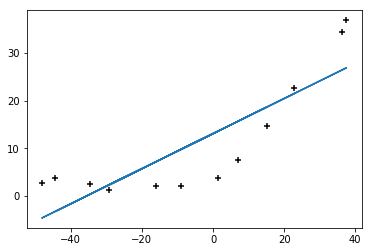

In [4]:
fmin = opt.minimize(fun=costegrad, x0=theta, args=(Xu,Y,0), method='TNC', jac=True, options={'maxiter':30})

plt.scatter(X,Y,marker='+', c='k')
plt.plot(X, (fmin.x[0] + fmin.x[1]*X))

Curvas de aprendizaje
---
Para comprobar que nuestro modelo aprende correctamente, utilizamos la función minimize para un rango de valores 0-i en cada iteración.

Vistos los resultados, necesitaríamos una hipótesis más expresiva.

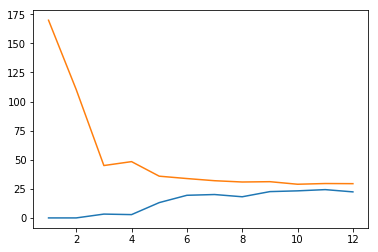

In [5]:
error = []
val = []   
for i in range(X.shape[0]):     
    xi = Xu[0:i+1]
    yi = Y[0:i+1]

    thi = opt.minimize(fun=costegrad, x0=theta, args=(xi,yi,reg),
                        method='TNC', jac=True, options={'maxiter':30}).x

    error.append(costegrad(thi, xi, yi, reg)[0]) 
    val.append(costegrad(thi, Xvalu, Yval, reg)[0]) 
    
plt.plot(np.arange(1, X.shape[0]+1, 1), error)
plt.plot(np.arange(1, X.shape[0]+1, 1), val)

Regresión polinomial
---
Función auxiliar para generar nuevos datos de entrenamiento.

In [6]:
def new_data(X,p):
    Xaux = np.array(X)
    for i in range(p-1):
        X = np.concatenate((X,Xaux**(i+2)),axis=1)
    return X

Con esta función, podremos normalizar los datos de cada atributo del dataset dado.

In [7]:
def normalizar(X):
    mu = np.mean(X,axis=0)
    mu = mu.reshape(mu.shape[0],1)
    sigma = np.std(X,axis=0)
    sigma = sigma.reshape(sigma.shape[0],1)
    X = (X - mu.T)/sigma.T
    
    return X,mu,sigma

Nuevos datos generados a partir del conjunto X, listos para usar.

In [8]:
X_data = new_data(X,8)
X_norm_data, mu, sigma = normalizar(X_data)
X_norm_data = np.concatenate((np.ones([X_norm_data.shape[0],1]), X_norm_data), axis=1)

Sobre estos nuevos datos, aplicamos de nuevo la función minimize y la regresión lineal sobre un conjunto de datos aumentado y normalizado entre los valores de X en intervalos de 0,05.

De esta forma, disponemos de una recta de predicción.

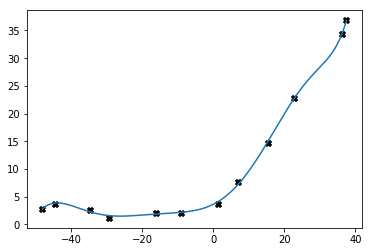

In [9]:
_X = X_norm_data
theta = np.zeros((_X.shape[1]))

reg = 0 
fmin = opt.minimize(fun=costegrad, x0=theta, args=(_X,Y,reg),
                        method='TNC', jac=True, options={'maxiter':2000}).x

Xaux = np.arange(min(X),max(X),0.05)
X_new2 = Xaux.reshape(Xaux.shape[0],1)
X_new2 = new_data(X_new2,8)
X_new2 = (X_new2 - mu.T)/sigma.T
X_new2 = np.concatenate((np.ones([X_new2.shape[0],1]),X_new2),axis=1)
    
plt.scatter(X,Y,marker='X', c='k')
plt.plot(Xaux, np.dot(X_new2,fmin))

Curvas de aprendizaje (reg. polinomial)
--
Al igual que antes, generaremos laa curva de aprendizaje sobre los valores aumentados y normalizados de X, haciendo lo mismo para los valores de Xval. 

Como se puede observar en la gráfica, pasado cierto punto, el error de los valores de validación aumenta, ya que está sobre-entrenando.

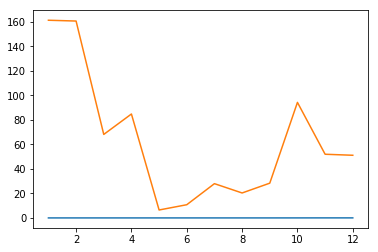

In [10]:
Xvalu = (new_data(Xval,8)-mu.T)/sigma.T
Xvalu = np.concatenate((np.ones([Xvalu.shape[0],1]),Xvalu),axis=1)
    
error = []
val = []
for i in range(X.shape[0]):
    xi = _X[0:i+1]
    yi = Y[0:i+1]
    thi = opt.minimize(fun=costegrad, x0=theta, args=(xi,yi,reg),
                        method='TNC', jac=True, options={'maxiter':2000}).x

    error.append(costegrad(thi, xi, yi, reg)[0])
    val.append(costegrad(thi, Xvalu, Yval, reg)[0])

plt.figure()
plt.plot(np.arange(1, X.shape[0]+1, 1), error)
plt.plot(np.arange(1, X.shape[0]+1, 1), val)

Selección parámetro Lambda
---
Para elegir el valor óptimo de este parámetro, hay que comprobar con cada valor el resultado de aplicarla sobre los conjuntos de entrenamiento y validación como llevamos haciendo en los anteriores ejercicios.

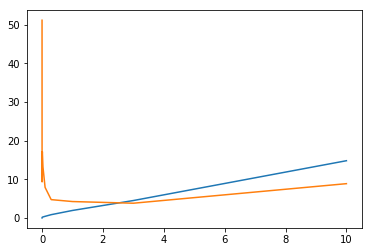

In [11]:
valores = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
error = []
val = []
for i in range(len(valores)):
    thi = opt.minimize(fun=costegrad, x0=theta, args=(X_norm_data,Y,valores[i]),
                        method='TNC', jac=True, options={'maxiter':2000}).x
        
    error.append(costegrad(thi, X_norm_data, Y, 0)[0])
    val.append(costegrad(thi, Xvalu, Yval, 0)[0])

plt.plot(valores, error)
plt.plot(valores, val)

Como se puede observar en la gráfica, el mejor valor de lambda parece ser 3. Para asegurarnos de que el error que produce es realmente bajo, lo comprobamos, aplicando la hipótesis sobre el conjunto de testeo (Xtest).

In [12]:
_Xtest = (new_data(Xtest,8) - mu.T)/sigma.T
_Xtest = np.concatenate((np.ones([Xtest.shape[0],1]),_Xtest),axis=1)
    
theta_fin = opt.minimize(fun=costegrad, x0=theta, 
                        args=(_X,Y,3),
                        method='TNC', jac=True, options={'maxiter':2000}).x
    
costegrad(theta_fin, _Xtest, Ytest, 0)[0]

3.5720488491943923